In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil

ModuleNotFoundError: No module named 'tensorflow'

# Restructure directories for images and masks

Apply thgis snipset to whichever directory you'll want to change

In [3]:
#  image_path='D:/Data OC/P8/Images/test'
#  image_dir=os.listdir(image_path)


#  for directory in image_dir[1:]:    
#      all_mask = os.listdir(image_path+'/'+directory)
#      for file in all_mask:
#          original = image_path+'/'+directory+'/'+file
#          target = image_path+'/'+'#all''/'+file
#          shutil.copyfile(original,target)

# Utilities

## Create mask from grey scale image

In [ ]:
def create_mask(img,cats):
    '''creates an mask from image and segmentation categories
    
    Args:
      img - PIL image
      cats - dict {'cat1':[value1,value2,value3,etc...],'cat2':[value1,value2,value3,etc...]}
    
    Returns:
      A mask of type np.array of dimension (shape(img),len(cats)) '''
    
    
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32) # convert img to np.array
    img=np.squeeze(img) #remove 1 dimension
    mask = np.zeros((img.shape[0], img.shape[1], len(cats)),dtype=int) # create a mask with zeros
    flat_cat = [val for cat in list(cats.values()) for val in cat] # create a list of all values associated with categories
    ca_min=min(flat_cat)
    ca_max=max(flat_cat)
    cats_names=list(cats.keys())
    
    #for each values associated with a category, fill in the mask with the corresponding category number
    for i in range(ca_min,ca_max):
            for idx,name in enumerate(cats_names):
                if i in cats[name]:
                    mask[:,:,idx] = np.logical_or(mask[:,:,idx],(img==i))
    return mask

## Construct colored image from mask

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
colors_palette=['black','purple','grey','yellow','forestgreen','skyblue','red','mediumblue']

In [ ]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [ ]:
def generate_img_from_mask(mask,cats,colors_palette=['b','g','r','c','m','y','k','w']):
    
    '''Generate a PIL image from a segmented mask and categorie cats with specified color palette for each cateorie
    
    Args:
      mask - numpy array of dimension (shape(img),len(cats))
      cats - dict {'cat1':[value1,value2,value3],'cat2':[value1,value2,value3]}
    
    Returns
      PIL image'''
    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')
    for cat in range(len(cats)):
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]
        
    return tf.keras.preprocessing.image.array_to_img(img_seg)         

## Display image, mask and prediction

In [ ]:
from PIL import ImageDraw

def get_concat_h(im1, im2):
    
    '''concatenate two PIL images horizontaly'''
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def show_results(img,mask,model):
    
    '''concatenates the img, the reference mask and the predicted mask'''

    img_norm = np.array(normalize_input_img(img))
    
    img_pred = model.predict(img_norm.reshape(1,128,256,3))[0]
    
    res = get_concat_h(get_concat_h(img,generate_img_from_mask(create_mask(mask,cats),cats)),generate_img_from_mask(img_pred,cats))
    
    return res

## Normalize input image

In [ ]:
def normalize_input_img(img):
    '''Normalize PIL image to fall in [-1,1] range, returns 3D numpy array'''
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32)
    img = img/127.5
    img -= 1
    return img

# Datasets

In [ ]:
image_train_path="D:/Data OC/P8/Full_def/images/train"
mask_train_path="D:/Data OC/P8/Full_def/masks/train"

image_test_path="D:/Data OC/P8/Full_def/images/test"
mask_test_path="D:/Data OC/P8/Full_def/masks/test"

In [ ]:
image_train_filename = os.listdir(image_train_path)
mask_train_filename = os.listdir(mask_train_path)

image_test_filename = os.listdir(image_test_path)
mask_test_filename = os.listdir(mask_test_path)

## EDA

### Number of images

In [15]:
len(image_train_filename)

2975

In [16]:
len(image_test_filename)

1525

In [ ]:
test_img_file="D:/Data OC/P8/Full_def/images/train/cologne_000100_000019_leftImg8bit.png"
test_mask_file="D:/Data OC/P8/Full_def/masks/train/cologne_000100_000019_gtFine_labelIds.png"
img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
mask = tf.keras.preprocessing.image.load_img(test_mask_file,target_size=(128,256),color_mode="grayscale")

### Class repartition

In [18]:
sums=[]
for file in mask_train_filename:
    mask_file=mask_train_path+'/'+file
    mask = tf.keras.preprocessing.image.load_img(mask_file,target_size=(128,256),color_mode="grayscale")
    mask_tensor = create_mask(mask,cats)
    sum=[]
    for i in range(8):
        sum.append(mask_tensor[:,:,i].sum())
    sums.append(sum)

In [19]:
sums=np.array(sums)

In [20]:
sums.sum(axis=0)

array([10476029, 37744963, 21198078,  1714486, 14632973,  3406053,
        1166331,  6789915])

Text(0.5, 1.0, 'class repartition')

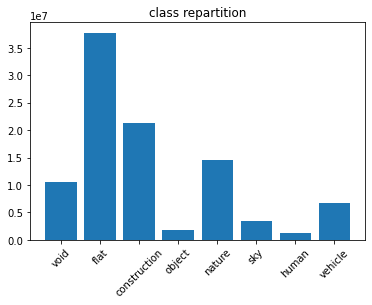

In [21]:
plt.bar(x=cats.keys(),height = sums.sum(axis=0),tick_label=list(cats.keys()))
plt.xticks(rotation=45)
plt.title('class repartition')

## Toy dataset

let's use 100 training samples and 20 test sample randomly selected in the dataset

In [ ]:
import random

In [ ]:
rand_index_train=random.sample(range(0,len(image_train_filename)-1),100)
rand_index_test=random.sample(range(0,len(image_test_filename)-1),20)

In [ ]:
image_train_filename=[image_train_filename[i] for i in rand_index_train]
mask_train_filename=[mask_train_filename[i] for i in rand_index_train]

image_test_filename=[image_test_filename[i] for i in rand_index_test]
mask_test_filename=[mask_test_filename[i] for i in rand_index_test]

create datasets

In [ ]:
X_train_toy=[]
for file in image_train_filename:
    img_file=image_train_path+'/'+file
    img = tf.keras.preprocessing.image.load_img(img_file,target_size=(128,256))    
    X_train_toy.append(normalize_input_img(img))
X_train_toy = np.array(X_train_toy)

In [26]:
X_train_toy.shape

(100, 128, 256, 3)

In [ ]:
y_train_toy=[]
for file in mask_train_filename:
    img_file=mask_train_path+'/'+file
    img = tf.keras.preprocessing.image.load_img(img_file,target_size=(128,256),color_mode="grayscale")
    y_train_toy.append(create_mask(img,cats))
y_train_toy = np.array(y_train_toy)

In [28]:
X_train_toy.shape

(100, 128, 256, 3)

In [ ]:
X_test_toy=[]
for file in image_test_filename:
    img_file=image_test_path+'/'+file
    img = tf.keras.preprocessing.image.load_img(img_file,target_size=(128,256))
    X_test_toy.append(normalize_input_img(img))
X_test_toy = np.array(X_test_toy)

In [30]:
X_test_toy.shape

(20, 128, 256, 3)

In [ ]:
y_test_toy=[]
for file in mask_test_filename:
    img_file=mask_test_path+'/'+file
    img = tf.keras.preprocessing.image.load_img(img_file,target_size=(128,256),color_mode="grayscale")
    y_test_toy.append(create_mask(img,cats))
y_test_toy = np.array(y_test_toy)

In [32]:
y_test_toy.shape

(20, 128, 256, 8)

# Data Augmentation


In [3]:
import imgaug.augmenters as iaa

ModuleNotFoundError: No module named 'imgaug'

## Gaussian Blur

In [ ]:
def blur_img(img):
    '''Add random blur to image, returns PIL image'''
    n = random.uniform(0,2.0) # Generating random value for sigma
    blur_transform = iaa.Sequential([iaa.GaussianBlur(sigma=n)])
    img_blur = blur_transform(image=tf.keras.preprocessing.image.img_to_array(img))

    return tf.keras.preprocessing.image.array_to_img(img_blur)

## Random zoom

In [ ]:
def zoom_img(img,mask):
    '''Add random zoom to image and mask, returns transformed PIL image and corresponding mask'''
    n = random.uniform(1,5) # Generating random value for sigma
    zoom_transform = iaa.Sequential([iaa.Affine(scale=n,order=0)]) # uses order=0 to avoid artifacts in mask
    img_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_zoom), tf.keras.preprocessing.image.array_to_img(mask_zoom,scale=False)

## Random brightness

In [ ]:
def brightness_img(img):
    '''Add random brightness to image, returns PIL image'''
    br_transform = iaa.Sequential([iaa.MultiplyBrightness((0.1,2))])
    img_br = br_transform(image=tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8))
    
    return tf.keras.preprocessing.image.array_to_img(img_br,scale=False)

## Horizontal Flip

In [ ]:
def flip_img(img,mask):
    '''Flips verticaly image, returns transformed PIL image and corresponding mask'''
    flip_transform = iaa.Sequential([iaa.Fliplr()])
    img_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_flip), tf.keras.preprocessing.image.array_to_img(mask_flip,scale=False)

## Tests

In [ ]:
img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
mask = tf.keras.preprocessing.image.load_img(test_mask_file,target_size=(128,256),color_mode="grayscale")

In [ ]:
img

In [ ]:
blur_img(img)

In [ ]:
zooms = zoom_img(img,mask)

In [ ]:
zooms[0]

In [ ]:
generate_img_from_mask(create_mask(zooms[1],cats),cats)

In [ ]:
brightness_img(img)

In [ ]:
flips = flip_img(img,mask)

In [ ]:
flips[0]

In [ ]:
generate_img_from_mask(create_mask(flips[1],cats),cats)

# Data generator

In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
class seg_gen(Sequence):
    
    def __init__(self, image_dir,
                 mask_dir,
                 batch_size,
                 img_height,
                 img_width,
                 cats,
                 sample_perc=100,
                 aug_blur=False,
                 aug_zoom=False,
                 aug_brightness=False,
                 aug_flip=False):
        
        self.image_dir = image_dir
        self.mask_dir =  mask_dir
        self.image_filename =  os.listdir(image_dir)
        self.image_filename.sort()
        self.mask_filename =  os.listdir(mask_dir)
        self.mask_filename.sort()
        self.sample_perc = sample_perc
        # Generate a sample
        rdm_index = random.sample(range(0,len(self.image_filename)),int(len(self.image_filename)*self.sample_perc/100))
        image_filename_sample = []
        for i in rdm_index:
            image_filename_sample.append(self.image_filename[i])
            
        mask_filename_sample = [] 
        for i in rdm_index:
            mask_filename_sample.append(self.mask_filename[i])
                
        self.image_filename = image_filename_sample
        self.mask_filename = mask_filename_sample
        
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.cats = cats
        self.sample_perc = sample_perc
        self.aug_blur = aug_blur
        self.aug_zoom = aug_zoom
        self.aug_brightness = aug_brightness
        self.aug_flip = aug_flip

    def __len__(self):
        return int(np.ceil(len(self.image_filename) / float(self.batch_size)))

    def __getitem__(self, idx):
        'generate one batch with random index'
        
        idx = np.random.randint(0,len(self.image_filename)-1, self.batch_size) #generate random index for the batch
        batch_img, batch_mask = [], []
        
        for i in idx:
            
            #filename
            img_file = self.image_dir+'/'+self.image_filename[i] 
            mask_file = self.mask_dir+'/'+self.mask_filename[i]
            
            #Load as PIL image and resize
            img = tf.keras.preprocessing.image.load_img(img_file,target_size=(self.img_height,self.img_width))
            mask = tf.keras.preprocessing.image.load_img(mask_file,target_size=(128,256),color_mode="grayscale")
                        
            #Normalize image and create mask from greyscale image
            img_norm = normalize_input_img(img)
            mask_tensor = create_mask(mask,self.cats)            
          
            #Add to the batch
            batch_img.append(img_norm)
            batch_mask.append(mask_tensor)
            
            #Image augmentation
            if self.aug_blur:
                batch_img.append(normalize_input_img(blur_img(img)))
                batch_mask.append(mask_tensor) # When using blur augmentation,the mask is not changed
            
            if self.aug_zoom:
                zooms = zoom_img(img,mask)
                batch_img.append(normalize_input_img(zooms[0]))
                batch_mask.append(create_mask(zooms[1],self.cats))
             
            if self.aug_brightness:
                batch_img.append(normalize_input_img(brightness_img(img)))
                batch_mask.append(mask_tensor) # When using brightness augmentation,the mask is not changed
            
            if self.aug_flip:
                flips = flip_img(img,mask)
                batch_img.append(normalize_input_img(flips[0]))
                batch_mask.append(create_mask(flips[1],self.cats))            
              
            
        return np.array(batch_img), np.array(batch_mask)

In [ ]:
train_gen = seg_gen(image_train_path,mask_train_path,10,128,256,cats,sample_perc=10,aug_blur=False,aug_zoom=False,aug_brightness=False,aug_flip=False)

In [117]:
len(train_gen)

3

In [ ]:
test_gen = seg_gen(image_test_path,mask_test_path,10,128,256,cats)

In [ ]:
batch_img,batch_mask = train_gen.__getitem__(1)

In [ ]:
tf.keras.preprocessing.image.array_to_img(batch_img[9])

In [4]:
tf.keras.preprocessing.image.array_to_img(generate_img_from_mask(batch_mask[9],cats))

NameError: name 'tf' is not defined

# Building VGG-16 + FCN-8 Model

## Define Pooling Block of VGG

In [ ]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
  '''
  Defines a block in the VGG network.

  Args:
    x (tensor) -- input image
    n_convs (int) -- number of convolution layers to append
    filters (int) -- number of filters for the convolution layers
    activation (string or object) -- activation to use in the convolution
    pool_size (int) -- size of the pooling layer
    pool_stried (int) -- stride of the pooling layer
    block_name (string) -- name of the block

  Returns:
    tensor containing the max-pooled output of the convolutions
  '''

  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                 activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)
    
  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, 
                                   strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

## Pretrained VGG weights

In [ ]:
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
# assign to a variable
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

## Define VGG-16

In [ ]:
def VGG_16(image_input):
  '''
  This function defines the VGG encoder.

  Args:
    image_input (tensor) - batch of images

  Returns:
    tuple of tensors - output of all encoder blocks plus the final convolution layer
  '''

  # create 5 blocks with increasing filters at each stage. 
  # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # create the vgg model
  vgg  = tf.keras.Model(image_input , p5)

  # load the pretrained weights you downloaded earlier
  vgg.load_weights(vgg_weights_path) 

  # number of filters for the output convolutional layers
  n = 4096

  # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. you will only need two of these in this particular exercise 
  # but we included it all in case you want to experiment with other types of decoders.
  return (p1, p2, p3, p4, c7)

## Define FCN 8 Decoder

In [ ]:
def fcn8_decoder(convs, n_classes):
  '''
  Defines the FCN 8 decoder.

  Args:
    convs (tuple of tensors) - output of the encoder network
    n_classes (int) - number of classes

  Returns:
    tensor with shape (height, width, n_classes) containing class probabilities
  '''

  # unpack the output of the encoder
  f1, f2, f3, f4, f5 = convs
  
  # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])
  
  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

## Define final model

In [ ]:
def segmentation_model():
  '''
  Defines the final segmentation model by chaining together the encoder and decoder.

  Returns:
    keras Model that connects the encoder and decoder networks of the segmentation model
  '''
  
  inputs = tf.keras.layers.Input(shape=(128,256,3))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 8)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  
  return model

In [ ]:
# instantiate the model and see how it looks
model_fcn8 = segmentation_model()
model_fcn8.summary()

# Buiding U-net model

## Encoder

In [57]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

## Bottleneck

In [62]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

## Decoder

In [60]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

## Final U-net model

In [63]:
OUTPUT_CHANNELS = 8

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 256,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model_unet = unet()

# see the resulting model architecture
model_unet.summary()


Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 128, 256, 64) 0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 256, 64) 36928       activation_10[0][0]              
_______________________________________________________________________________________

# Metrics and Loss functions

In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import CategoricalCrossentropy

Here, we want to compare predition and ground truth as far as class prediction is concerned

## IoU

In [ ]:
def class_wise_IoU(y_true,y_pred):
    
    nb_class = y_true.shape[3]
    
    # for each pixel, get the slice number which has the highest probability
    y_true = K.argmax(y_true, axis=3)
    y_pred = K.argmax(y_pred,axis=3)
    
    class_wise_iou = []
  
    smoothening_factor = 0.00001 # to avoid eventual division by 0
    
    for i in range(nb_class):
        pred = tf.cast((y_pred == i),tf.float32)
        truth = tf.cast((y_true == i),tf.float32)
        intersection = K.sum(pred * truth)
        y_true_area = K.sum(truth)
        y_pred_area = K.sum(pred)
        combined_area = y_true_area + y_pred_area
    
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)  
    
    return tf.convert_to_tensor(class_wise_iou)

In [ ]:
def mean_IoU(y_true,y_pred):   
    y_true = tf.cast(y_true, tf.float32)   
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    return score

## Dice coef

In [ ]:
def class_wise_dice(y_true,y_pred):
    
    nb_class = y_true.shape[3]
    
    # for each pixel, get the slice number which has the highest probability
    y_true = K.argmax(y_true, axis=3)
    y_pred = K.argmax(y_pred,axis=3)
    
    class_wise_dice = []
  
    smoothening_factor = 0.00001 # to avoid eventual division by 0
    
    for i in range(nb_class):
        
        pred = tf.cast((y_pred == i),tf.float32)
        truth = tf.cast((y_true == i),tf.float32)
        intersection = K.sum(pred * truth)
        y_true_area = K.sum(truth)
        y_pred_area = K.sum(pred)
        combined_area = y_true_area + y_pred_area
    
        dice = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice.append(dice)  
    
    return tf.convert_to_tensor(class_wise_dice)    

In [ ]:
def mean_dice(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

## Dice loss

In [ ]:
#Loss must be decreasing fonction
def dice_loss(y_true, y_pred):

    return (1 - mean_dice(y_true,y_pred))

## Total Loss : combination of cross entropy and dice

In [ ]:
cce = tf.keras.losses.CategoricalCrossentropy()

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loss = cce(y_true, y_pred).numpy() + (3*dice_loss(y_true, y_pred))
    return loss

# Callbacks

## Early stopping

In [93]:
es = tf.keras.callbacks.EarlyStopping(mode='min', monitor='val_loss', patience=6, verbose=1)

# Toy training

## With categorical crossentropy

In [66]:
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)


In [118]:
model_unet.compile(loss='categorical_crossentropy',
              #optimizer=sgd,
              metrics=['accuracy','categorical_crossentropy',mean_dice,mean_IoU],
              run_eagerly=True
              )

In [119]:
model_unet.fit(train_gen,epochs=100)

Epoch 1/100
30/30 [==============================] - 562s 19s/step - loss: 2.8678 - accuracy: 0.3570 - categorical_crossentropy: 2.8678 - mean_dice: 0.2489 - mean_IoU: 0.1439
Epoch 2/100
30/30 [==============================] - 576s 19s/step - loss: 1.7936 - accuracy: 0.4304 - categorical_crossentropy: 1.7936 - mean_dice: 0.2745 - mean_IoU: 0.1596
Epoch 3/100
30/30 [==============================] - 585s 20s/step - loss: 1.8247 - accuracy: 0.4563 - categorical_crossentropy: 1.8247 - mean_dice: 0.3113 - mean_IoU: 0.1857
Epoch 4/100
30/30 [==============================] - 619s 21s/step - loss: 1.4564 - accuracy: 0.4867 - categorical_crossentropy: 1.4564 - mean_dice: 0.3475 - mean_IoU: 0.2115
Epoch 5/100
30/30 [==============================] - 599s 20s/step - loss: 1.9801 - accuracy: 0.5056 - categorical_crossentropy: 1.9801 - mean_dice: 0.3704 - mean_IoU: 0.2304
Epoch 6/100
30/30 [==============================] - 596s 20s/step - loss: 1.2251 - accuracy: 0.5554 - categorical_crossentro

KeyboardInterrupt: 

In [96]:
hist = model.fit(X_train_toy,y_train_toy,validation_data=(X_test_toy,y_test_toy),batch_size=10,epochs=3,callbacks=[es])

Epoch 1/3
10/10 [==============================] - 114s 11s/step - loss: 0.8667 - accuracy: 0.1450 - mean_dice: 0.1082 - mean_IoU: 0.0587 - val_loss: 0.8703 - val_accuracy: 0.1157 - val_mean_dice: 0.0259 - val_mean_IoU: 0.0145
Epoch 2/3
10/10 [==============================] - 108s 11s/step - loss: 0.8531 - accuracy: 0.1547 - mean_dice: 0.1113 - mean_IoU: 0.0607 - val_loss: 0.8842 - val_accuracy: 0.1088 - val_mean_dice: 0.0245 - val_mean_IoU: 0.0136
Epoch 3/3
10/10 [==============================] - 110s 11s/step - loss: 0.8133 - accuracy: 0.1935 - mean_dice: 0.1219 - mean_IoU: 0.0680 - val_loss: 0.9103 - val_accuracy: 0.0853 - val_mean_dice: 0.0197 - val_mean_IoU: 0.0107


In [266]:
hist.history

{'loss': [0.4987359941005707],
 'accuracy': [0.8378078937530518],
 'mean_dice': [0.6114801168441772],
 'mean_IoU': [0.5210873484611511],
 'class_wise_IoU': [0.5210873484611511],
 'val_loss': [3.2043380737304688],
 'val_accuracy': [0.10031738132238388],
 'val_mean_dice': [0.022788025438785553],
 'val_mean_IoU': [0.012539705261588097],
 'val_class_wise_IoU': [0.012539705261588097]}

# Building smaller image dataset for Uploading

To save ressource, we'll resize all images (train,test,validation) to 128x256

In [105]:
def reduce_size_folder(origin_path,dest_path,height,width):
    filenames = os.listdir(origin_path)
    for file in filenames:
        origin_file=origin_path+'/'+file
        img = tf.keras.preprocessing.image.load_img(origin_file,target_size=(height,width))
        img.save(dest_path+'/'+file) 

In [106]:
reduce_size_folder('D:/Data OC/P8/Images/val/#all',
                   'D:/Data OC/P8/Images/val/#all_red',
                   128,256)

In [107]:
reduce_size_folder('D:/Data OC/P8/Images/test/#all',
                   'D:/Data OC/P8/Images/test/#all_red',
                   128,256)

In [108]:
reduce_size_folder('D:/Data OC/P8/Images/train/#all',
                   'D:/Data OC/P8/Images/train/#all_red',
                   128,256)

In [109]:
reduce_size_folder('D:/Data OC/P8/Masks/train/#all',
                   'D:/Data OC/P8/Masks/train/#all_red',
                   128,256)

In [110]:
reduce_size_folder('D:/Data OC/P8/Masks/test/#all',
                   'D:/Data OC/P8/Masks/test/#all_red',
                   128,256)

In [111]:
reduce_size_folder('D:/Data OC/P8/Masks/val/#all',
                   'D:/Data OC/P8/Masks/val/#all_red',
                   128,256)

# Test Bench

In [220]:
# Load a pretrained model
model = tf.keras.models.load_model('fcn_full_train')

In [196]:
test_img_file="D:/Data OC/P8/Full_def/images/val/frankfurt_000000_005543_leftImg8bit.png"
test_mask_file="D:/Data OC/P8/Full_def/masks/val/frankfurt_000000_005543_gtFine_labelIds.png"
img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
img_norm = np.array(normalize_input_img(img))
mask = tf.keras.preprocessing.image.load_img(test_mask_file,target_size=(128,256),color_mode="grayscale")

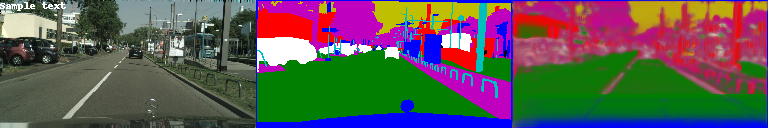

In [223]:
show_results(img,mask,model_unet)

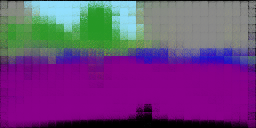

In [108]:
generate_img_from_mask(model.predict(img_norm.reshape(1,128,256,3))[0],cats,colors_palette=colors_palette)

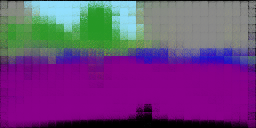

In [109]:
generate_img_from_mask(model.predict(img_norm.reshape(1,128,256,3))[0],cats,colors_palette=colors_palette)